## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>

**Задача**

На основании имеющихся данных о клиентах банка требуется построить модель для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1($\beta$ = 1) > 0.5 при Precision > 0.5 и Recall > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной (0 или 1, а НЕ вероятность) для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Подключение библиотек и скриптов**

In [501]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import chi2_contingency, probplot, shapiro, ttest_ind, mannwhitneyu

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, learning_curve
import pickle

In [502]:
import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [503]:
# input
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

# output
TRAIN_FULL_PATH = 'training_project_train_full.csv'
TRAIN_PART_PATH = 'training_project_train_part_b.csv'
TEST_PART_PATH = 'training_project_test_part.csv'
SCALER_FILE_PATH = 'scaler.pkl'

**Хи-квадрат Пирсона**

In [504]:
def calc_chi2(data, target, values, feature, category1, category2, aggfunc, treshold):
    table = data.loc[data[feature].isin([category1, category2]),[values, feature, target]]
    table[values] = table.index
    chi2_table = table.pivot_table(values = values,
                                   index=feature, 
                                   columns=target, 
                                   aggfunc=aggfunc)
    chi2, p, dof, expected = chi2_contingency(chi2_table, correction=False)
    
    if p < treshold:
        print(f'Необходимо разделение на категории {category1} и {category2} для {feature}')
    else:
        print(f'Категории {category1} и {category2} для {feature} можно объединить')

**Балансировка классов**

In [505]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

**Логистическая регрессия**

In [506]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**Загрузка данных**

In [507]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

**Обзор обучающего датасета**

In [508]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Размер обучающего датасета**

In [509]:
df_train.shape

(7500, 17)

**Размер тестового датасета**

In [510]:
df_test.shape

(2500, 16)

**Количество и типы данных**

In [511]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [512]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Обработка пропусков

In [513]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [514]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Обработка выбросов

**ANNUAL INCOME - заполним пропуски медианой**

In [515]:
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace=True)

**YEARS IN CURRENT JOB - заполним пропуски модой**

In [516]:
df_train['Years in current job'].fillna(df_train['Years in current job'].mode()[0], inplace=True)
df_test['Years in current job'].fillna(df_test['Years in current job'].mode()[0], inplace=True)

**MONTH SINCE LAST DELINQUENT - пока думаю, что делать с признаком, слишком много пропущенных значений, возможно удалю**

In [517]:
df_train = df_train.drop('Months since last delinquent', axis=1)
df_test = df_test.drop('Months since last delinquent', axis=1)

**BANKRUPTCIES - заполним пропуски модой**

In [518]:
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].mode()[0], inplace=True)
df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].mode()[0], inplace=True)

**CREDIT SCORE - заполним пропуски медианой**

In [519]:
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)
df_test['Credit Score'].fillna(df_test['Credit Score'].median(), inplace=True)

### Проверим пропуски

In [520]:
df_train.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

In [521]:
df_test.isna().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

**Целевая переменная**

In [522]:
target_name = 'Credit Default'

**Приведение типов**

In [523]:
df_train['Years in current job'] = df_train['Years in current job'].map({'10+ years':'10', '9 years':'9', '8 years':'8',
                                                                            '7 years':'7', '6 years':'6', '5 years':'5', 
                                                                            '4 years':'4', '3 years':'3', '2 years':'2', 
                                                                            '1 year':'1', '< 1 year':'0'}).astype(int)

df_test['Years in current job'] = df_test['Years in current job'].map({'10+ years':'10', '9 years':'9', '8 years':'8',
                                                                            '7 years':'7', '6 years':'6', '5 years':'5', 
                                                                            '4 years':'4', '3 years':'3', '2 years':'2', 
                                                                            '1 year':'1', '< 1 year':'0'}).astype(int)

In [524]:
df_train['Term'] = df_train['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)
df_test['Term'] = df_test['Term'].map({'Long Term':'1', 'Short Term':'0'}).astype(int)

In [525]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)
for cat_colname in df_train.select_dtypes(include='object').columns:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)

In [526]:
df_train = df_train.drop(df_train.select_dtypes(include='object').columns, axis=1)
df_test = df_test.drop(df_test.select_dtypes(include='object').columns, axis=1)

In [527]:
df_train.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,482087.0,10,0.0,11.0,26.3,685960.0,1.0,1.0,0,99999999.0,...,0,0,0,0,0,0,0,0,0,0
1,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,0.0,1,264968.0,...,0,0,0,0,0,0,0,0,0,0
2,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,0.0,0,99999999.0,...,0,0,0,0,0,0,0,0,0,0
3,805068.0,6,0.0,8.0,22.5,147400.0,1.0,1.0,0,121396.0,...,0,0,0,0,0,0,0,0,0,0
4,776264.0,8,0.0,13.0,13.6,385836.0,1.0,0.0,0,125840.0,...,0,0,0,0,0,0,0,0,0,0


In [528]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 7500 non-null   float64
 1   Years in current job          7500 non-null   int32  
 2   Tax Liens                     7500 non-null   float64
 3   Number of Open Accounts       7500 non-null   float64
 4   Years of Credit History       7500 non-null   float64
 5   Maximum Open Credit           7500 non-null   float64
 6   Number of Credit Problems     7500 non-null   float64
 7   Bankruptcies                  7500 non-null   float64
 8   Term                          7500 non-null   int32  
 9   Current Loan Amount           7500 non-null   float64
 10  Current Credit Balance        7500 non-null   float64
 11  Monthly Debt                  7500 non-null   float64
 12  Credit Score                  7500 non-null   float64
 13  Cre

In [529]:
df_test.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,1178475.0,4,0.0,9.0,12.5,220968.0,0.0,0.0,0,162470.0,...,0,0,0,0,0,0,0,0,0,0
1,231838.0,1,0.0,6.0,32.7,55946.0,0.0,0.0,0,78298.0,...,1,0,0,0,0,0,0,0,0,0
2,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,0,200178.0,...,0,0,0,0,0,0,0,0,0,0
3,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,0.0,0,217382.0,...,0,0,0,0,0,0,0,0,0,0
4,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,1,777634.0,...,0,0,0,0,0,0,0,0,0,0


In [530]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   int32  
 2   Tax Liens                     2500 non-null   float64
 3   Number of Open Accounts       2500 non-null   float64
 4   Years of Credit History       2500 non-null   float64
 5   Maximum Open Credit           2500 non-null   float64
 6   Number of Credit Problems     2500 non-null   float64
 7   Bankruptcies                  2500 non-null   float64
 8   Term                          2500 non-null   int32  
 9   Current Loan Amount           2500 non-null   float64
 10  Current Credit Balance        2500 non-null   float64
 11  Monthly Debt                  2500 non-null   float64
 12  Credit Score                  2500 non-null   float64
 13  Hom

**Выделение групп признаков**

In [531]:
base_feature_names = df_train.columns.drop(target_name).tolist()
base_feature_names

['Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding']

In [532]:
new_feature_names = df_train.columns.drop([target_name]).tolist()

len(base_feature_names), len(new_feature_names)

(32, 32)

**Обзор количественных признаков**

In [533]:
df_train.describe()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,...,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.00000
mean,1.325286e+06,6.084133,0.030133,11.130933,18.317467,9.451537e+05,0.170000,0.116933,0.259200,1.187318e+07,...,0.054933,0.005333,0.009467,0.001467,0.088667,0.000267,0.003467,0.004933,0.001067,0.00200
std,7.567551e+05,3.640717,0.271604,4.908924,7.041946,1.602622e+07,0.498598,0.346904,0.438225,3.192612e+07,...,0.227865,0.072840,0.096842,0.038272,0.284281,0.016329,0.058780,0.070069,0.032645,0.04468
min,1.645970e+05,0.000000,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,9.311330e+05,3.000000,0.000000,8.000000,13.500000,2.792295e+05,0.000000,0.000000,0.000000,1.801690e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.168386e+06,6.000000,0.000000,10.000000,17.000000,4.781590e+05,0.000000,0.000000,0.000000,3.095730e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.499974e+06,10.000000,0.000000,14.000000,21.800000,7.935015e+05,0.000000,0.000000,1.000000,5.198820e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.014934e+07,10.000000,7.000000,43.000000,57.700000,1.304726e+09,7.000000,4.000000,1.000000,1.000000e+08,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


**Обзор номинативных/категориальных переменных**

In [534]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [535]:
cat_features = ['Home Ownership_Have Mortgage',
                'Home Ownership_Home Mortgage',
                'Home Ownership_Own Home',
                'Home Ownership_Rent',
                'Purpose_business loan',
                'Purpose_buy a car',
                'Purpose_buy house',
                'Purpose_debt consolidation',
                'Purpose_educational expenses',
                'Purpose_home improvements',
                'Purpose_major purchase',
                'Purpose_medical bills',
                'Purpose_moving',
                'Purpose_other',
                'Purpose_renewable energy',
                'Purpose_small business',
                'Purpose_take a trip',
                'Purpose_vacation',
                'Purpose_wedding',
                'Years in current job',
                'Term']
cat_features

['Home Ownership_Have Mortgage',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business loan',
 'Purpose_buy a car',
 'Purpose_buy house',
 'Purpose_debt consolidation',
 'Purpose_educational expenses',
 'Purpose_home improvements',
 'Purpose_major purchase',
 'Purpose_medical bills',
 'Purpose_moving',
 'Purpose_other',
 'Purpose_renewable energy',
 'Purpose_small business',
 'Purpose_take a trip',
 'Purpose_vacation',
 'Purpose_wedding',
 'Years in current job',
 'Term']

**Обзор непрерывных переменных**

In [536]:
for num_colname in df_train.select_dtypes(include='float64').columns:
    print(str(num_colname) + '\n\n' + str(df_train[num_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Annual Income

1168386.0    1558
1058376.0       4
1043651.0       4
1161660.0       4
1338113.0       4
             ... 
1141254.0       1
7907382.0       1
1534478.0       1
972040.0        1
1654786.0       1
Name: Annual Income, Length: 5478, dtype: int64
****************************************************************************************************

Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
****************************************************************************************************

Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
32.0      6
33.0      6
3

In [537]:
num_features = [col for col in base_feature_names if col not in cat_features]
num_features

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [538]:
bin_feature = [col for col in new_feature_names if col not in cat_features + num_features]
bin_feature

[]

In [539]:
selected_feature = cat_features + num_features + bin_feature
print(len(selected_feature))

32


**Нормализация данных**

In [540]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[base_feature_names] = scaler.fit_transform(df_norm[base_feature_names])

In [541]:
df_norm.head()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Term,Current Loan Amount,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-1.114304,1.075647,-0.110953,-0.026674,1.133645,-0.016174,1.664779,2.545732,-0.591517,2.760520,...,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766
1,-0.396190,1.075647,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.337099,1.690569,-0.363620,...,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766
2,-0.758385,0.526268,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.337099,-0.591517,2.760520,...,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766
3,-0.687478,-0.023111,-0.110953,-0.637847,0.593985,-0.049781,1.664779,2.545732,-0.591517,-0.368118,...,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766
4,-0.725543,0.526268,-0.110953,0.380774,-0.669954,-0.034902,1.664779,-0.337099,-0.591517,-0.367978,...,-0.241094,-0.073225,-0.097761,-0.038325,-0.311919,-0.016332,-0.058981,-0.070412,-0.032677,-0.044766


**Сохранение модели для нормализации данных**

In [542]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

**Разбиваем на обучающую и валидационную выборку**

In [543]:
X = df_train[base_feature_names]
y = df_train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5250, 32), (2250, 32), (5250,), (2250,))

**Балансировка целевой переменной**

In [544]:
y_train.value_counts()

0    3771
1    1479
Name: Credit Default, dtype: int64

In [545]:
y_train.mean()

0.2817142857142857

In [546]:
y_train.value_counts(normalize=True)

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

In [547]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [548]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

X_train.shape, y_train.shape

((6729, 32), (6729,))

**Сохранение обучающего и тестового датасетов**

In [549]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [550]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

## Построение и оценка базовых моделей

**Логистическая регрессия**

In [551]:
%%time

model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      3771
           1       0.63      0.51      0.57      2958

    accuracy                           0.66      6729
   macro avg       0.65      0.64      0.64      6729
weighted avg       0.65      0.66      0.65      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1616
           1       0.45      0.49      0.47       634

    accuracy                           0.69      2250
   macro avg       0.62      0.63      0.63      2250
weighted avg       0.70      0.69      0.69      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1237  379
1                321  313
Wall time: 528 ms


**k ближайших соседей**

In [552]:
%%time

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      3771
           1       0.74      0.71      0.72      2958

    accuracy                           0.76      6729
   macro avg       0.76      0.76      0.76      6729
weighted avg       0.76      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.76      0.68      0.72      1616
           1       0.36      0.45      0.40       634

    accuracy                           0.62      2250
   macro avg       0.56      0.57      0.56      2250
weighted avg       0.65      0.62      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1098  518
1                348  286
Wall time: 1.09 s


**Бустинговые алгоритмы**

*XGBoost*

In [553]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[00:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3771
           1       0.98      0.96      0.97      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1616
           1       0.50      0.45      0.48       634

    accuracy                           0.72      2250
   macro avg       0.65      0.64      0.64      2250
weighted avg       0.71      0.72      0.72      2250

CONFUSION MATRIX

col_0

*LightGBM*

In [554]:
%%time

model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3771
           1       0.95      0.87      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.55      0.47      0.51       634

    accuracy                           0.74      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1366  250
1                334  300
Wall time: 368 ms


*CatBoost*

In [555]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3771
           1       0.93      0.84      0.88      2958

    accuracy                           0.90      6729
   macro avg       0.91      0.90      0.90      6729
weighted avg       0.91      0.90      0.90      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.48      0.51       634

    accuracy                           0.75      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                330  304
Wall time: 9.7 s


In [556]:
cat_features_names = [i for i, col in enumerate(selected_feature) if col in cat_features]
cat_features_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [557]:
X_train[selected_feature].iloc[:,cat_features_names].columns

Index(['Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Years in current job', 'Term'],
      dtype='object')

In [558]:
selected_feature = cat_features + num_features
X = df_norm[base_feature_names]
y = df_norm[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((5250, 32), (2250, 32), (5250,), (2250,))

In [559]:
scale = int(y_train[y_train == 0].shape[0] / y_train[y_train == 1].shape[0])
scale

2

In [560]:
%%time

model_catb = catb.CatBoostClassifier(scale_pos_weight=scale, silent=True, random_state=21)
model_catb.fit(X_train, y_train, cat_features_names=cat_features_names)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TypeError: fit() got an unexpected keyword argument 'cat_features_names'

In [561]:
model_catb.fit(X_train,
               y_train,
               cat_features_names=cat_features_names,
               verbose=False,
               plot=True);

TypeError: fit() got an unexpected keyword argument 'cat_features_names'

## Выбор лучшей модели и подбор гиперпараметров

In [562]:
model_catb = catb.CatBoostClassifier(cat_features=cat_features, 
                                     scale_pos_weight=scale, 
                                     silent=True, 
                                     random_state=21)

**Подбор гиперпараметров**

In [563]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
          'max_depth':[4, 6, 8]
         }

In [564]:
# from sklearn.model_selection import StratifiedKFold

cv = KFold(n_splits=3, random_state=21, shuffle=True)

In [565]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, random_state=21, n_jobs=-1)
rs.fit(X, y)

CatBoostError: Invalid type for cat_feature[non-default value idx=0,feature_idx=1]=1.0756473140670004 : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [566]:
rs.best_params_

{'n_estimators': 700, 'max_depth': 6}

In [567]:
rs.best_score_

nan

**Обучение и оценка финальной модели**

In [568]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=6, scale_pos_weight=scale,
                                      silent=True, random_state=21, early_stopping_rounds=50)
final_model.fit(X_train, y_train, cat_features_names=cat_features_names)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TypeError: fit() got an unexpected keyword argument 'cat_features_names'

In [570]:
preds = pd.DataFrame()
preds['Credit Default'] = y_test_pred

preds.to_csv('VMikhaylovskaya_predictions.csv', index=False)

### Анализ целевой переменной

**Обзор распределения**

In [193]:
df_train[target_name].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

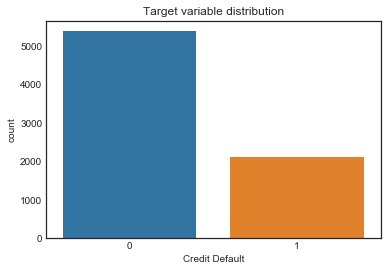

In [194]:
sns.countplot(x=target_name, data=df_train)
plt.title('Target variable distribution');

### Анализ категориальных признаков

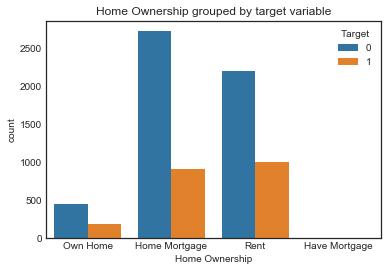

In [195]:
sns.countplot(x="Home Ownership", hue=target_name, data=df_train)
plt.title('Home Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right');

*Наблюдение*

Из графика видно, что все значения категорий признака Home Ownership имеют схожие доли в разрезе целевой переменной. Если это так, то можно будет объединить их в одну категорию.

*Гипотеза*

Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
Критерий: Хи-квадрат Пирсона
Уровень значимости  𝛼=0.05 
Критическая область: двухсторонняя
Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий Home Mortgage, Rent, Own Home, Have Mortgage признака Home Ownership в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа. Если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

**Сформируем выборку и рассчитаем наблюдаемые частоты**

In [ ]:
calc_chi2(data=df_train, target=target_name, values='id',
          feature='Home Ownership', category1='Own Home', 
          category2='Home Mortgage', aggfunc='count', treshold=0.05)

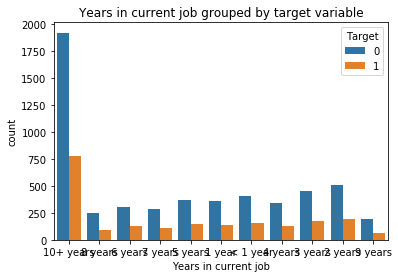

In [65]:
sns.countplot(x="Years in current job", hue=target_name, data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right');

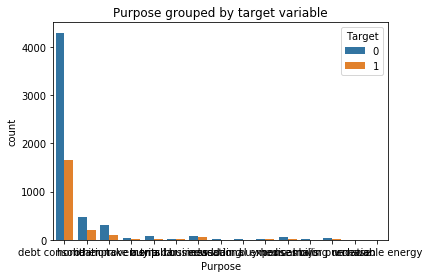

In [66]:
sns.countplot(x="Purpose", hue=target_name, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right');

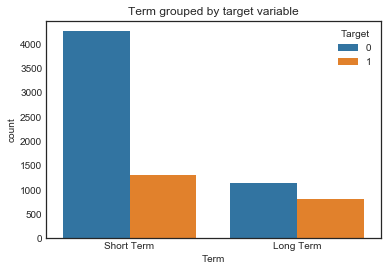

In [70]:
sns.countplot(x="Term", hue=target_name, data=df_train)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right');
plt.style.use('seaborn-white')